In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import math
import inspect
import scipy as sp
from scipy import optimize


In [2]:
class ProgressBar:
    __slots__ = ['description', 'overall', 'done', 'prevp', 'len', 'closed']
    def __init__(self, description, overall):
        self.description = description
        self.overall = overall
        self.done = 0
        self.prevp = -1
        self.len = 40
        self.closed = False
        self.__show()
    def go(self):
        self.done += 1
        self.__show()
    def __show(self):
        p100 = int(round(100.0 * self.done / self.overall))
        if p100 > self.prevp:
            p = int(round(self.len * self.done / self.overall))
            print("\r%s: [%s%s] %d%%" % (self.description, '#' * p, '.' * (self.len - p), p100), end='')
            self.prevp = p100
            if p == self.len:
                self.close()
    def close(self):
        if not self.closed:
            self.closed = True
            print()


In [3]:
def InitializeDataset(name):
    dataset = pd.read_csv(name)
    return dataset.values

Dataset = InitializeDataset('chips.txt')

In [ ]:
MetricCount = 3
TransformsCount = 6

__Metrics = [lambda x, y : la.norm(x - y),
           lambda x, y : la.norm(x - y, ord = 1),
           lambda x, y : la.norm(x - y, ord = np.inf)]
def QueryMetric(mInd, tInd):
    if tInd == 0:
        trans = lambda x, y: np.array([x, y])
    elif tInd == 1:
        trans = lambda x, y: np.array([x, y, x ** 2 + y ** 2])
    elif tInd == 2:
        trans = lambda x, y: np.array([x - y, x + y])1
    elif tInd == 3:
        trans = lambda x, y: np.array([x, y, x ** 2, y ** 2])
    elif tInd == 4:
        trans = lambda x, y: np.array([3 * x + 2 * y, x])
    elif tInd == 5:
        trans = lambda x, y: np.array([x, y, x ** 2, y ** 2, x * y])
        #trans = lambda x, y: np.array([math.sqrt(x ** 2 + y ** 2), math.atan2(x, y)])

    def ret(x, y):
        x = trans(x[0], x[1])
        y = trans(y[0], y[1])
        return __Metrics[mInd](x, y)
    return ret


In [ ]:
# K-d tree


def partition(arr, axis, first, last):
    pivot = arr[last][axis]
    i = first - 1
    for j in range(first, last):
        if arr[j][axis] <= pivot:
            i += 1
            arr[i], arr[j] = arr[j], np.copy(arr[i])
    arr[i + 1], arr[last] = arr[last], np.copy(arr[i + 1])
    return i + 1

def kth(arr, axis, first, last, k):
    if first >= last:
        return arr[k]
    pivot = arr[last]
    pivotIndex = partition(arr, axis, first, last)
    if k < pivotIndex:
        return kth(arr, axis, first, pivotIndex - 1, k)
    else:
        return kth(arr, axis, pivotIndex + 1, last, k)
        

class Node:
    def __init__ (self, loc, l, r):
        self.location = loc
        self.left = l
        self.right = r
        
            
def CreateKdTree(points, depth = 0):
    if (points.shape[0] == 0): return None
    dimension = points.shape[0]
    curAxis = depth % dimension
    median = points.shape[0] // 2
    loc = kth(points, curAxis, 0, points.shape[0] - 1, median)
    left = points[:median]
    right = points[1 + median:]
    return Node(loc, CreateKdTree(left, depth + 1), CreateKdTree(right, depth + 1))
    

def GetKnn(root, metricIndex):
    return 
    print(arr)
    
arr = np.array([[1, 2, 3], [1, 4, 3], [1, 7, 8],[1, 502, 1], [1, 500, 1], [1, 1, 1], [1, 10, 1], [1, -5, 2], [1, 100, 10], [1, 98, 15]])
print(arr.shape[0] // 2)
#print(kth(arr, 1, 0, arr.shape[0] - 1, arr.shape[0] // 2))

#print(arr[:(arr.shape[0] // 2)].shape)

#print(arr)

tree = CreateKdTree(arr)
print(tree.left.left.left.left)
    
        
    
    

In [ ]:
def GetKNearest(u, objects, k, Ro):
    values = np.apply_along_axis(lambda x : Ro(u, x[:2]), 1, objects)
    result = objects[np.argsort(values)]
    return result[:k], result[k]

In [18]:
def calculateScore(answers, predicted):
    #TODO: calculate a confusion matrix
    accuracy = False
    if (accuracy):
        sum = 0
        for i in range(0, predicted.shape[0]):
            if (answers[i] == predicted[i]):
                sum += 1
        return sum / predicted.shape[0];
    else:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(0, predicted.shape[0]):
            if (answers[i] == 0):
                if (predicted[i] == 0):
                    TN += 1
                else: FP += 1
            if (answers[i] == 1):
                if (predicted[i] == 0):
                    FN += 1
                else: TP += 1
        print ("TP = %i " % TP)
        print ("FP = %i " % FP)
        print ("TN = %i " % TN)
        print ("FN = %i " % FN)
        if (TP + FP == 0): return 0
        if (TP + FN == 0): return 0
        if (TP == 0): return 0
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        
        return 2 * precision * recall / (precision + recall)
    return 0
    
def calc_harmonic(a):
    return sum(a) / len(a)
    return len(a) / sum(1.0 / (x + 1) for x in a) - 1

In [ ]:
def Partition(dataset, blockSize):
    np.random.shuffle(dataset)
    ret = []
    cnt = dataset.shape[0] // blockSize
    last = 0
    for i in range(cnt):
        c = (dataset.shape[0] + i) // cnt
        ret.append(dataset[last : last + c])
        last += c
    ret = np.array(ret)
    return cnt, ret

    
def KnnClassificator(trainObjects, labelSet, metricIndex, transIndex, BlockSize = 29, T = 10):
    Ro = QueryMetric(metricIndex, transIndex)
    def Classificator(trainObjects, labelSet, k):
        def InnerClassificator(u):
            kNearest, afterKNearest = GetKNearest(u, trainObjects, k, Ro)
            labels = {label: 0 for label in labelSet}
            for object in kNearest:
                FiniteKernel = lambda x : 1 / x
                labels[object[2]] +=  1 * FiniteKernel(Ro(u, object[:2]) / (Ro(u, afterKNearest[:2])))
            return max(labels.items(), key=lambda t: t[1])[0]
        return InnerClassificator
    k = -1
    prevValue = 0
    maxK = trainObjects.shape[0] // 2;
    pbar = ProgressBar('Choose best k', maxK)
    for l in range(1, maxK + 1):
        #print("Try new k = %i:" % (l), end='')
#         curValue, allValues = 0, 0
        scores = []
        for t in range(0, T):
            q, partitions = Partition(trainObjects, BlockSize)
            for i in range(0, len(partitions)):
                training_set = []
                
                for j in range(len(partitions)):
                    if i != j:
                        training_set.extend(partitions[j])
                training_set = np.array(training_set)
                classificator = Classificator(training_set, labelSet, l)
               
                answers = np.array([])
                predicted = np.array([])
                for p in partitions[i]:
                    
                    answers = np.append(answers, p[2])
                    predicted = np.append(predicted, classificator(p[:2]))
                
                score = calculateScore(answers, predicted)
                #print(score)
                scores.append(score)
#                 curValue += score
                
#         curValue /= T * q
        #print(curValue)
#         print(T * BlockSize, allValues)
        #         print(" score = %f" % (curValue))
        curValue = calc_harmonic(scores)
        if (k == -1 or prevValue < curValue):
            k = l
            prevValue = curValue
        pbar.go()
    pbar.close()
    print("Best k is %i with score %f" % (k, prevValue))
    return k, Classificator(trainObjects, labelSet, k)



In [ ]:
stdout = sys.stdout
with open("file.txt", "w") as f:
    #sys.stdout = f
    for t in range(1, 4):
        for mi in range(0, MetricCount):
            for ti in range(0, TransformsCount):
                for blockSize in range(6, 15):
                    print("with T = %i, BlockSize = %i, MetricIndex = %i, TransformIndex = %i" % 
                        (t, blockSize, mi, ti))
                    k, classificator = KnnClassificator(Dataset, [0, 1], mi, ti, blockSize, t)
    sys.stdout = stdout

In [ ]:
 k, classificator = KnnClassificator(Dataset, [0, 1], 1, 1, 10, 1)

In [ ]:
points = Dataset[:, : 2]
classes = Dataset[:, 2]
h = .01
x_min, x_max = points[:, 0].min() - 0.2, points[:, 0].max() + 0.2
y_min, y_max = points[:, 1].min() - 0.2, points[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

test = np.c_[xx.ravel(), yy.ravel()]

totalCount = test.shape[0]

result = np.array([])
pbar = ProgressBar('Apply classificator', totalCount)
for x in test:
    result = np.append(result, classificator(x))
    pbar.go()
pbar.close()
result = result.reshape(xx.shape)

In [6]:
def createSVM(data, y, f, C = 1) :
    N = len(data)
    hFunc = lambda i, j: y[i] * y[j] * np.dot(f(data[i]), f(data[j]))
    h = np.fromfunction(np.vectorize(hFunc), (N, N), dtype=int)
    c = C * np.ones(N)
    start = np.random.randn(N)
    cons = [ {"type": "ineq", "fun": lambda x: c - x, "jac": lambda x: -np.eye(N)}
           , {"type": "ineq", "fun": lambda x: x,                       "jac": lambda x:  np.eye(N)}
           , {"type": "eq",   "fun": lambda x: np.dot(y, x),            "jac": lambda x: y} ]
    opt = {"disp": False}
    loss = lambda x: 0.5 * np.dot(x.T, np.dot(h, x)) - np.dot(c, x)
    jac = lambda x: np.dot(x.T, h) - c
    res = sp.optimize.minimize(loss, start, jac=jac, constraints=cons, method="SLSQP", options=opt)
    w = np.dot(res.x * y, np.apply_along_axis(lambda x : f(x), 1 ,data))
    
    
    w0 = 0
    count = 0
    for i, w_i in enumerate(res.x):
        if w_i > 0:
            w0 += np.dot(w, f(data[i])) - y[i]
            count += 1
    w0 /= count
    return lambda x: np.sign((np.dot(w, f(x)) - w0)) * 0.5 + 0.5


In [27]:
np.random.shuffle(Dataset)
points = Dataset[:, : 2]
classes = Dataset[:, 2] * 2 - 1

svm = createSVM(points, classes, lambda x: np.array([1.45 * (x[0]**2 + x[1]**2) , x[0], x[1]]), 50)

predicted = np.array([])
for p in points:
    predicted = np.append(predicted, svm(p))
print("score %f" % calculateScore(predicted, Dataset[:, 2]))

h = .01
x_min, x_max = points[:, 0].min() - 0.2, points[:, 0].max() + 0.2
y_min, y_max = points[:, 1].min() - 0.2, points[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

test = np.c_[xx.ravel(), yy.ravel()]

totalCount = test.shape[0]

result = np.array([])
pbar = ProgressBar('Apply classificator', totalCount)
for x in test:
    result = np.append(result, svm(x))
    pbar.go()
pbar.close()
result = result.reshape(xx.shape)



TP = 47 
FP = 11 
TN = 49 
FN = 11 
score 0.810345
Apply classificator: [########################################] 100%


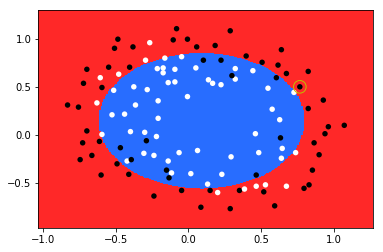

In [28]:
cmap_light = ListedColormap(['#ff2828', '#286dff'])
# cmap_bold = ListedColormap(['#a50000', '#0c00a5'])
cmap_bold = ListedColormap(['#000000', '#ffffff'])
plt.figure()
plt.rcParams["figure.figsize"] = list(map(lambda x: x * 1, plt.rcParams["figure.figsize"]))
plt.pcolormesh(xx, yy, result, cmap=cmap_light)
plt.scatter(points[:, 0], points[:, 1],  c = classes,cmap=cmap_bold,linewidths=0, s=30)

x = np.random.randn(60) 
y = np.random.randn(60)

plt.scatter( 0.76555,  0.50219, s=160, facecolors='none', edgecolors='y')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()